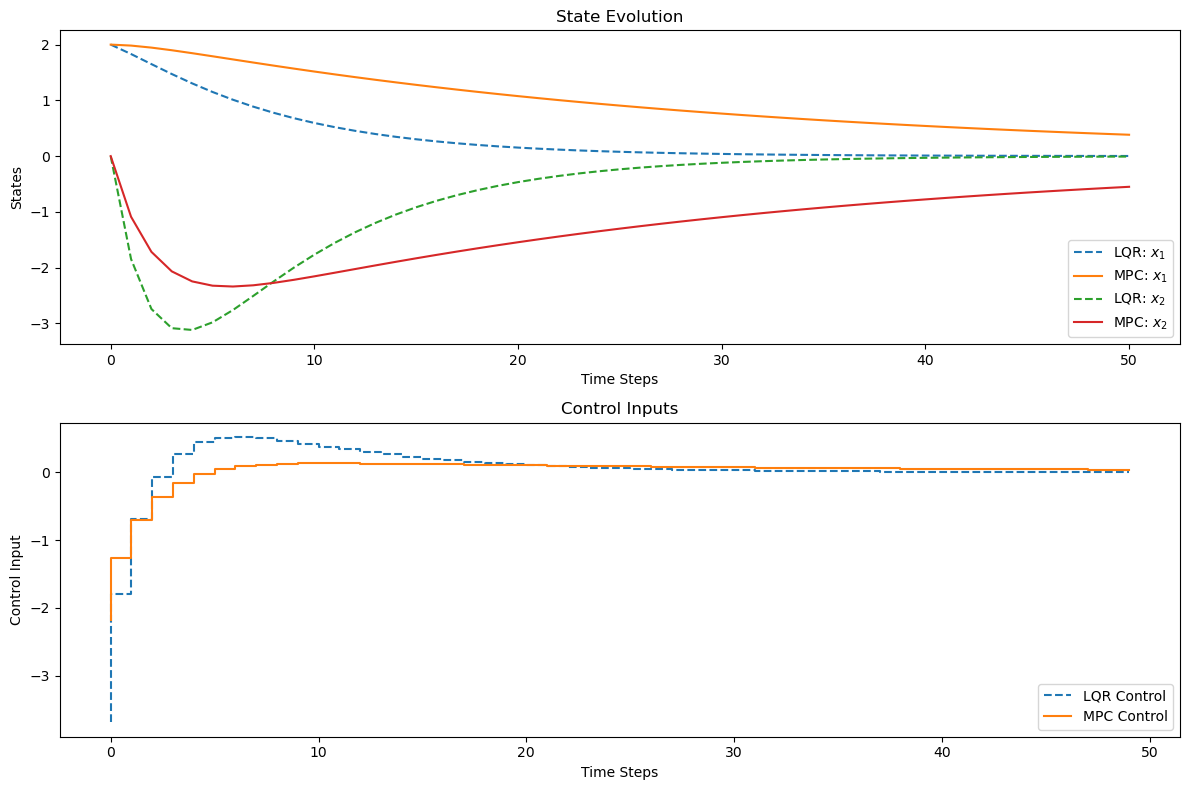

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are
from scipy.optimize import minimize
# Change log: 8 Jan 25 to add the file in git

# Define system dynamics
A = np.array([[1.1, 0.1], [0.0, 1.0]])
B = np.array([[0.1], [0.5]])
Q = np.eye(2)  # State penalty
R = np.array([[1]])  # Control penalty

# Initial state
x0 = np.array([2.0, 0.0])

# Simulation parameters
horizon = 50  # Number of steps
N = 10  # Prediction horizon for MPC

# # Function to simulate system
# def simulate_system(A, B, u, x):
#     return A @ x + B @ u

# Function to simulate system
# def simulate_system(A, B, u, x):
#     u = np.array(u).reshape(-1, 1)  # Ensure control input is a column vector
#     return A @ x + B @ u
def simulate_system(A, B, u, x):
    x = np.array(x).reshape(-1, 1)  # Ensure state is a column vector
    u = np.array(u).reshape(-1, 1)  # Ensure control input is a column vector
    return (A @ x + B @ u).flatten()  # Return as a flat array


# LQR Controller
def lqr(A, B, Q, R):
    P = solve_discrete_are(A, B, Q, R)  # Solve Riccati equation
    K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)  # Compute gain matrix
    return K

K_lqr = lqr(A, B, Q, R)


# MPC Controller
def mpc_cost(U, x0, A, B, Q, R, N):
    U = np.array(U).reshape(-1, 1)
    x = x0
    cost = 0
    for i in range(N):
        u = U[i]
        cost += x.T @ Q @ x + u.T @ R @ u
        x = A @ x + B @ u
    return cost

def solve_mpc(x0, A, B, Q, R, N, u_bounds=(-10, 10)):
    U0 = np.zeros(N)  # Initial guess for control inputs
    bounds = [u_bounds] * N  # Bounds for each control input
    result = minimize(mpc_cost, U0, args=(x0, A, B, Q, R, N), bounds=bounds, method='SLSQP')
    return result.x

# Simulate LQR and MPC
x_lqr = [x0]
x_mpc = [x0]
u_lqr = []
u_mpc = []

for _ in range(horizon):
    # LQR Control
    u_lqr_k = -K_lqr @ x_lqr[-1]
    x_lqr.append(simulate_system(A, B, u_lqr_k, x_lqr[-1]))
    u_lqr.append(u_lqr_k)
    
    # MPC Control
    u_mpc_k = solve_mpc(x_mpc[-1], A, B, Q, R, N)[0]

    x_mpc.append(simulate_system(A, B, np.array([u_mpc_k]), x_mpc[-1]))

    u_mpc.append(u_mpc_k)


x_lqr = np.array(x_lqr)
x_mpc = np.array(x_mpc)
u_lqr = np.array(u_lqr)
u_mpc = np.array(u_mpc)

# Plot Results
plt.figure(figsize=(12, 8))

# Plot states
plt.subplot(2, 1, 1)
plt.plot(x_lqr[:, 0], label='LQR: $x_1$', linestyle='--')
plt.plot(x_mpc[:, 0], label='MPC: $x_1$', linestyle='-')
plt.plot(x_lqr[:, 1], label='LQR: $x_2$', linestyle='--')
plt.plot(x_mpc[:, 1], label='MPC: $x_2$', linestyle='-')
plt.title('State Evolution')
plt.xlabel('Time Steps')
plt.ylabel('States')
plt.legend()

# Plot control inputs
plt.subplot(2, 1, 2)
plt.step(range(horizon), u_lqr, label='LQR Control', linestyle='--')
plt.step(range(horizon), u_mpc, label='MPC Control', linestyle='-')
plt.title('Control Inputs')
plt.xlabel('Time Steps')
plt.ylabel('Control Input')
plt.legend()

plt.tight_layout()
plt.show()
